##### Copyright 2021 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax_augreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers

Model repository published with the paper

[**How to train your ViT? Data, Augmentation, and Regularization in Vision
Transformers**](https://arxiv.org/abs/2106.10270)

This Colab shows how to
[find checkpoints](#scrollTo=F4SLGDtFxlsC)
in the repository, how to
[select and load a model](#scrollTo=wh_SLkQtQ6K4)
form the repository and use it for inference
([also with PyTorch](#scrollTo=1nMyWmDycpAo)),
and how to
[fine-tune on a dataset](#scrollTo=iAruT3YOxqB6).

For more details, please refer to the repository:

https://github.com/google-research/vision_transformer/

Note that this Colab directly uses the unmodified code from the repository. If
you want to modify the modules and persist your changes, you can do all that
using free GPUs and TPUs without leaving the Colab environment - see

https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb

### Imports

In [2]:
# Fetch vision_transformer repository.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer


Cloning into 'vision_transformer'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 37 (delta 4), reused 15 (delta 1), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [3]:
# Install dependencies.
!pip install -qr vision_transformer/vit_jax/requirements.txt

     |████████████████████████████████| 57 kB 3.4 MB/s 
     |████████████████████████████████| 76 kB 5.0 MB/s 
     |████████████████████████████████| 179 kB 10.1 MB/s 
     |████████████████████████████████| 88 kB 5.8 MB/s 
     |████████████████████████████████| 168.3 MB 36 kB/s 


In [4]:
# Import files from repository.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import models
from vit_jax import train
from vit_jax.configs import augreg as augreg_config
from vit_jax.configs import models as models_config

In [5]:
# Connect to TPUs if runtime type is of type TPU.

import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  # Otherwise print information about GPU.
  !nvidia-smi

Thu Jul 29 06:07:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Some more imports used in this Colab.

import glob
import os
import random
import shutil
import time

from absl import logging
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

pd.options.display.max_colwidth = None
logging.set_verbosity(logging.INFO)  # Shows logs during training.

### Explore checkpoints

This section contains shows how to use the `index.csv` table for model
selection.

See
[`vit_jax.checkpoint.get_augreg_df()`](https://github.com/google-research/vision_transformer/blob/ed1491238f5ff6099cca81087c575a215281ed14/vit_jax/checkpoint.py#L181-L228)
for a detailed description of the individual columns

In [7]:
# Load master table from Cloud.
with tf.io.gfile.GFile('gs://vit_models/augreg/index.csv') as f:
  df = pd.read_csv(f)

In [8]:
# This is a pretty large table with lots of columns:
print(f'loaded {len(df):,} rows')
df.columns

loaded 51,509 rows


Index(['name', 'ds', 'epochs', 'lr', 'aug', 'wd', 'do', 'sd', 'best_val',
       'final_val', 'final_test', 'adapt_ds', 'adapt_lr', 'adapt_steps',
       'adapt_resolution', 'adapt_final_val', 'adapt_final_test', 'params',
       'infer_samples_per_sec', 'filename', 'adapt_filename'],
      dtype='object')

In [9]:
# Number of distinct checkpoints
len(tf.io.gfile.glob('gs://vit_models/augreg/*.npz'))

52268

In [10]:
# Any column prefixed with "adapt_" pertains to the fine-tuned checkpoints.
# Any column without that prefix pertains to the pre-trained checkpoints.
len(set(df.filename)), len(set(df.adapt_filename))

(759, 51509)

In [15]:
df.name.unique()

array(['Ti/16', 'S/32', 'B/16', 'L/16', 'R50+L/32', 'R26+S/32', 'S/16',
       'B/32', 'R+Ti/16', 'B/8'], dtype=object)

In [17]:
# Upstream AugReg parameters (section 3.3):
(
df.groupby(['ds', 'name', 'wd', 'do', 'sd', 'aug']).filename
  .count().unstack().unstack().unstack()
  .dropna(1, 'all').fillna(0).astype(int)
  .iloc[:7]  # Just show beginning of a long table.
)

aug              light0     light1     medium1  ... none strong1     strong2    
sd                  0.0 0.1    0.0 0.1     0.0  ...  0.1     0.0 0.1     0.0 0.1
do                  0.0 0.1    0.0 0.1     0.0  ...  0.1     0.0 0.1     0.0 0.1
ds  name    wd                                  ...                             
i1k B/16    0.03     68  68     68  68      68  ...   68      68  68      68  68
            0.10     68  68     68  68      68  ...   68      68  68      68  68
    B/32    0.03     68  68     68  68      68  ...   68      68  68      68  68
            0.10     68  68     68  68      68  ...   68      68  68      68  68
    L/16    0.03     68  68     68  68      68  ...   68      68  68      68  68
            0.10     68  68     68  68      68  ...   68      68  68      68  68
    R+Ti/16 0.03     68  68     68  68      68  ...   68      68  68      68  68

[7 rows x 14 columns]

In [18]:
# Downstream parameters (table 4)
# (Imbalance in 224 vs. 384 is due to recently added B/8 checkpoints)
(
df.groupby(['adapt_resolution', 'adapt_ds', 'adapt_lr', 'adapt_steps']).filename
  .count().astype(str).unstack().unstack()
  .dropna(1, 'all').fillna('')
)

adapt_steps                      500                ... 10000 20000      
adapt_lr                         0.001 0.003 0.010  ... 0.030 0.010 0.030
adapt_resolution adapt_ds                           ...                  
224              cifar100                           ...   759            
                 imagenet2012                       ...         759   759
                 kitti             759   759   759  ...                  
                 oxford_iiit_pet   759   759   759  ...                  
                 resisc45                           ...   759            
384              cifar100                           ...   756            
                 imagenet2012                       ...         756   755
                 kitti             756   756   756  ...                  
                 oxford_iiit_pet   756   756   756  ...                  
                 resisc45                           ...   756            

[10 rows x 14 columns]

In [19]:
# Let's first select the "best checkpoint" for every model. We show in the
# paper (section 4.5) that one can get a good performance by simply choosing the
# best model by final pre-train validation accuracy ("final-val" column).
# Pre-training with imagenet21k 300 epochs (ds=="i21k") gives the best
# performance in almost all cases (figure 6, table 5).
best_filenames = set(
    df.query('ds=="i21k"')
    .groupby('name')
    .apply(lambda df: df.sort_values('final_val').iloc[-1])
    .filename
)

# Select all finetunes from these models.
best_df = df.loc[df.filename.apply(lambda filename: filename in best_filenames)]

# Note: 9 * 68 == 612
len(best_filenames), len(best_df)

(10, 646)

In [20]:
best_df.columns

Index(['name', 'ds', 'epochs', 'lr', 'aug', 'wd', 'do', 'sd', 'best_val',
       'final_val', 'final_test', 'adapt_ds', 'adapt_lr', 'adapt_steps',
       'adapt_resolution', 'adapt_final_val', 'adapt_final_test', 'params',
       'infer_samples_per_sec', 'filename', 'adapt_filename'],
      dtype='object')

In [21]:
# Note that this dataframe contains the models from the "i21k_300" column of
# table 3:
best_df.query('adapt_ds=="imagenet2012"').groupby('name').apply(
    lambda df: df.sort_values('adapt_final_val').iloc[-1]
)[[
   # Columns from upstream
   'name', 'ds', 'filename',
   # Columns from downstream
   'adapt_resolution', 'infer_samples_per_sec','adapt_ds', 'adapt_final_test', 'adapt_filename',
]].sort_values('infer_samples_per_sec')

,name,ds,filename,adapt_resolution,infer_samples_per_sec,adapt_ds,adapt_final_test,adapt_filename
name,,,,,,,,
L/16,L/16,i21k,L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0,384,49.87,imagenet2012,0.85588,L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
B/16,B/16,i21k,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0,384,137.92,imagenet2012,0.85486,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384
S/16,S/16,i21k,S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0,384,300.12,imagenet2012,0.83728,S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384
R50+L/32,R50+L/32,i21k,R50_L_32-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1,384,326.73,imagenet2012,0.85992,R50_L_32-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_384
R26+S/32,R26+S/32,i21k,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0,384,560.40,imagenet2012,0.83846,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
Ti/16,Ti/16,i21k,Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0,384,609.58,imagenet2012,0.78220,Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384
B/32,B/32,i21k,B_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0,384,954.94,imagenet2012,0.83586,B_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
S/32,S/32,i21k,S_32-i21k-300ep-lr_0.001-aug_none-wd_0.1-do_0.0-sd_0.0,384,2153.94,imagenet2012,0.79584,S_32-i21k-300ep-lr_0.001-aug_none-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
R+Ti/16,R+Ti/16,i21k,R_Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0,384,2425.77,imagenet2012,0.75402,R_Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384


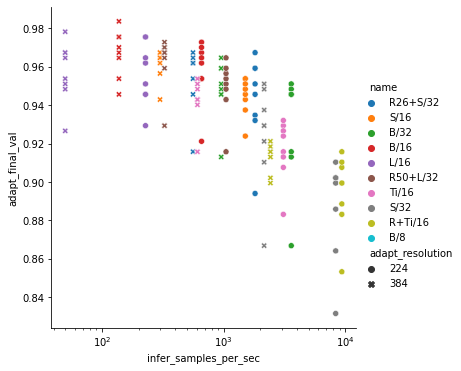

In [22]:
# Visualize the 2 (resolution) * 9 (models) * 8 (lr, steps) finetunings for a
# single dataset (Pets37).
# Note how larger models get better scores up to B/16 @384 even on this tiny
# dataset, if pre-trained sufficiently.
sns.relplot(
    data=best_df.query('adapt_ds=="oxford_iiit_pet"'),
    x='infer_samples_per_sec',
    y='adapt_final_val',
    hue='name',
    style='adapt_resolution'
)
plt.gca().set_xscale('log');

In [23]:
# More details for a single pre-trained checkpoint.
best_df.query('name=="R26+S/32" and adapt_ds=="oxford_iiit_pet"')[[
  col for col in best_df.columns if col.startswith('adapt_')
]].sort_values('adapt_final_val')

,adapt_ds,adapt_lr,adapt_steps,adapt_resolution,adapt_final_val,adapt_final_test,adapt_filename
5730,oxford_iiit_pet,0.030,2500,224,0.894022,0.867539,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_2k-lr_0.03-res_224
5762,oxford_iiit_pet,0.030,2500,384,0.915761,0.894794,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_2k-lr_0.03-res_384
5734,oxford_iiit_pet,0.030,500,224,0.932065,0.916326,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_0k-lr_0.03-res_224
5731,oxford_iiit_pet,0.010,2500,224,0.934783,0.908694,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_2k-lr_0.01-res_224
5732,oxford_iiit_pet,0.003,2500,224,0.945652,0.926410,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_2k-lr_0.003-res_224
5763,oxford_iiit_pet,0.010,2500,384,0.945652,0.934315,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_2k-lr_0.01-res_384
5735,oxford_iiit_pet,0.010,500,224,0.951087,0.928046,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_0k-lr_0.01-res_224
5766,oxford_iiit_pet,0.030,500,384,0.953804,0.941128,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_0k-lr_0.03-res_384
5733,oxford_iiit_pet,0.001,2500,224,0.959239,0.931044,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_2k-lr_0.001-res_224
5737,oxford_iiit_pet,0.001,500,224,0.959239,0.923412,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_0k-lr_0.001-res_224


### Load a checkpoint

In [24]:
# Select a value from "adapt_filename" above that is a fine-tuned checkpoint.
filename = 'R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_0k-lr_0.003-res_384'

tfds_name = filename.split('--')[1].split('-')[0]
model_config = models_config.AUGREG_CONFIGS[filename.split('-')[0]]
resolution = int(filename.split('_')[-1])
path = f'gs://vit_models/augreg/{filename}.npz'

print(f'{tf.io.gfile.stat(path).length / 1024 / 1024:.1f} MiB - {path}')

137.8 MiB - gs://vit_models/augreg/R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--oxford_iiit_pet-steps_0k-lr_0.003-res_384.npz


In [25]:
# Fetch dataset that the checkpoint was finetuned on.
# (Note that automatic download does not work with imagenet2012)
ds, ds_info = tfds.load(tfds_name, with_info=True)
ds_info

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: oxford_iiit_pet/3.2.0
INFO:absl:Load dataset info from /tmp/tmpjdu62jcgtfds
INFO:absl:Generating dataset oxford_iiit_pet (/root/tensorflow_datasets/oxford_iiit_pet/3.2.0)


INFO:absl:Downloading http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz into /root/tensorflow_datasets/downloads/robots.ox.ac.uk_vgg_pets_annotationsL8B_bMDM0_iUhyDddl6Yu-1togBm2g5ZH8E6r80wOQo.tar.gz.tmp.4604a2666aa54d328f47b684e6b8c5c7...
INFO:absl:Downloading http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz into /root/tensorflow_datasets/downloads/robots.ox.ac.uk_vgg_pets_imageswMR1o1DWRq_DHWToagdXedb7P88RHpceK3WqG77VVwU.tar.gz.tmp.87f3d2b8bfb14abcadb60abb95bc060d...
INFO:absl:Generating split train


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteADR8WE/oxford_iiit_pet-train.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteADR8WE/oxford_iiit_pet-train.tfrecord. Shard lengths: [920, 920, 920, 920]
INFO:absl:Generating split test


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteADR8WE/oxford_iiit_pet-test.tfrecord


INFO:absl:Done writing /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteADR8WE/oxford_iiit_pet-test.tfrecord. Shard lengths: [917, 917, 918, 917]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/oxford_iiit_pet/3.2.0


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

In [26]:
# Get model instance - no weights are initialized yet.
model = models.VisionTransformer(
    num_classes=ds_info.features['label'].num_classes, **model_config)

In [27]:
# Load a checkpoint from cloud - for large checkpoints this can take a while...
params = checkpoint.load(path)

In [28]:
# Get a single example from dataset for inference.
d = next(iter(ds['test']))

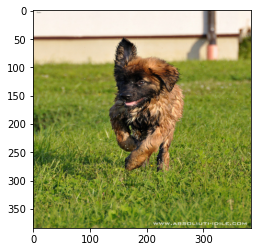

In [29]:
def pp(img, sz):
  """Simple image preprocessing."""
  img = tf.cast(img, float) / 255.0
  img = tf.image.resize(img, [sz, sz])
  return img

plt.imshow(pp(d['image'], resolution));

In [30]:
# Inferance on batch with single example.
logits, = model.apply({'params': params}, [pp(d['image'], resolution)], train=False)

INFO:absl:Starting the local TPU driver.
INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO:absl:Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


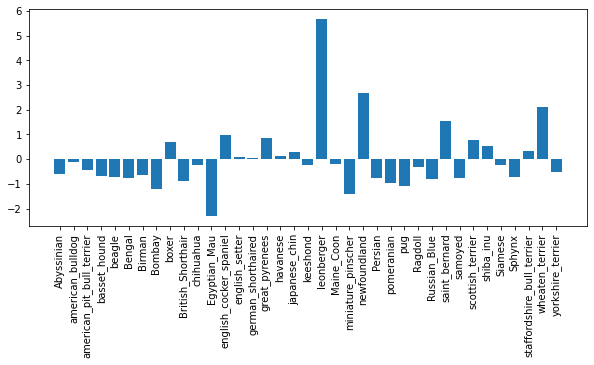

In [31]:
# Plot logits (you can use tf.nn.softmax() to show probabilities instead).
plt.figure(figsize=(10, 4))
plt.bar(list(map(ds_info.features['label'].int2str, range(len(logits)))), logits)
plt.xticks(rotation=90);

#### Using `timm`

If you know PyTorch, you're probably already familiar with `timm`.

If not yet - it's your lucky day! Please check out their docs here:

https://rwightman.github.io/pytorch-image-models/

In [32]:
# Checkpoints can also be loaded directly into timm...
!pip install timm
import timm
import torch

     |████████████████████████████████| 376 kB 6.9 MB/s 


In [33]:
# For available model names, see here:
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer_hybrid.py
timm_model = timm.create_model(
    'vit_small_r26_s32_384', num_classes=ds_info.features['label'].num_classes)

# Non-default checkpoints need to be loaded from local files.
if not tf.io.gfile.exists(f'{filename}.npz'):
  tf.io.gfile.copy(f'gs://vit_models/augreg/{filename}.npz', f'{filename}.npz')
timm.models.load_checkpoint(timm_model, f'{filename}.npz')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [34]:
def pp_torch(img, sz):
  """Simple image preprocessing for PyTorch."""
  img = pp(img, sz)
  img = img.numpy().transpose([2, 0, 1])  # PyTorch expects NCHW format.
  return torch.tensor(img[None])

with torch.no_grad():
  logits, = timm_model(pp_torch(d['image'], resolution)).detach().numpy()

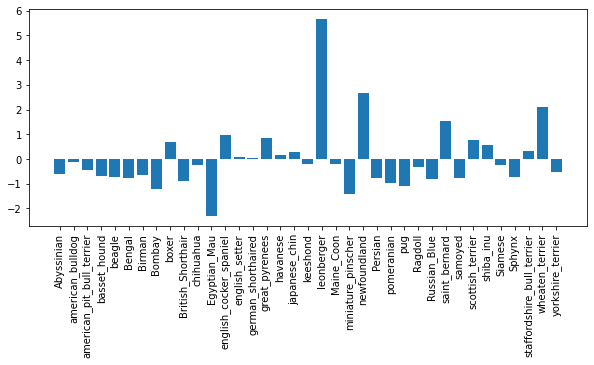

In [35]:
# Same results as above (since we loaded the same checkpoint).
plt.figure(figsize=(10, 4))
plt.bar(list(map(ds_info.features['label'].int2str, range(len(logits)))), logits)
plt.xticks(rotation=90);

### Fine-tune

You want to be connected to a TPU or GPU runtime for fine-tuning.

Note that here we're just calling into the code. For more details see the
annotated Colab

https://colab.sandbox.google.com/github/google-research/vision_transformer/blob/linen/vit_jax.ipynb

Also note that Colab GPUs and TPUs are not very powerful. To run this code on
more powerful machines, see:

https://github.com/google-research/vision_transformer/#running-on-cloud

In particular, note that due to the Colab "TPU Node" setup, transfering data to
the TPUs is realtively slow (for example the smallest `R+Ti/16` model trains
faster on a single GPU than on 8 TPUs...)

#### TensorBoard

In [ ]:
# Launch tensorboard before training - maybe click "reload" during training.
%load_ext tensorboard
%tensorboard --logdir=./workdirs

#### From tfds

In [37]:
# Create a new temporary workdir.
workdir = f'./workdirs/{int(time.time())}'
workdir

'./workdirs/1627539136'

In [38]:
# Get config for specified model.

# Note that we can specify simply the model name (in which case the recommended
# checkpoint for that model is taken), or it can be specified by its full
# name.
config = augreg_config.get_config('R_Ti_16')

# A very small tfds dataset that only has a "train" split. We use this single
# split both for training & evaluation by splitting it further into 90%/10%.
config.dataset = 'tf_flowers'
config.pp.train = 'train[:90%]'
config.pp.test = 'train[90%:]'
# tf_flowers only has 3670 images - so the 10% evaluation split will contain
# 360 images. We specify batch_eval=120 so we evaluate on all but 7 of those
# images (remainder is dropped).
config.batch_eval = 120

# Some more parameters that you will often want to set manually.
# For example for VTAB we used steps={500, 2500} and lr={.001, .003, .01, .03}
config.base_lr = 0.01
config.shuffle_buffer = 1000
config.total_steps = 100
config.warmup_steps = 10
config.accum_steps = 0  # Not needed with R+Ti/16 model.
config.pp['crop'] = 224

In [39]:
# Call main training loop. See repository and above Colab for details.
state = train.train_and_evaluate(config, workdir)

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: tf_flowers/3.0.1
INFO:absl:Load dataset info from /tmp/tmprx4ogu7ltfds
INFO:absl:Reading dataset from tfds "tf_flowers"
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: tf_flowers/3.0.1
INFO:absl:Load dataset info from /tmp/tmpd_sq954qtfds
INFO:absl:Generating dataset tf_flowers (/root/tensorflow_datasets/tf_flowers/3.0.1)
local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



INFO:absl:Load dataset info from /root/tensorflow_datasets/tf_flowers/3.0.1.incompleteXSDU19
INFO:absl:Constructing tf.data.Dataset for split train[:90%], from /root/tensorflow_datasets/tf_flowers/3.0.1
INFO:absl:Load dataset info from /root/tensorflow_datasets/tf_flowers/3.0.1




Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/tf_flowers/3.0.1
INFO:absl:Reusing dataset tf_flowers (/root/tensorflow_datasets/tf_flowers/3.0.1)
INFO:absl:Constructing tf.data.Dataset for split train[90%:], from /root/tensorflow_datasets/tf_flowers/3.0.1
INFO:absl:Load dataset info from /root/tensorflow_datasets/tf_flowers/3.0.1
INFO:absl:<PrefetchDataset shapes: {image: (1, 512, 224, 224, 3), label: (1, 512, 5)}, types: {image: tf.float32, label: tf.float32}>
INFO:absl:<PrefetchDataset shapes: {image: (1, 120, 224, 224, 3), label: (1, 120, 5)}, types: {image: tf.float32, label: tf.float32}>
INFO:absl:Selected fillename="R_Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0" for "R_Ti_16" with final_val=0.390
INFO:absl:Found no checkpoint file at ./workdirs/1627539136
INFO:absl:Will start/continue training at initial_step=1
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:387: UserWarning: jax.host_count has been renamed to jax.process_count. This alias wi

workdirs/1627539136/checkpoint_100


#### From JPG files

The codebase supports training directly form JPG files on the local filesystem
instead of `tfds` datasets. Note that the throughput is somewhat reduced, but
that only is noticeable for very small models.

The main advantage of `tfds` datasets is that they are versioned and available
globally.

In [40]:
base = '.'  # Store data on VM (ephemeral).

In [41]:
# Uncomment below lines if you want to download & persist files in your Google
# Drive instead. Note that Colab VMs are reset (i.e. files are deleted) after
# some time of inactivity. Storing data to Google Drive guarantees that it is
# still available next time you connect from a new VM.

# Note that this is significantly slower than reading from the VMs locally
# attached file system!

# from google.colab import drive
# drive.mount('/gdrive')
# base = '/gdrive/My Drive/vision_transformer_images'

In [42]:
# Download some dataset & unzip.
! rm -rf '$base/flower_photos'; mkdir -p '$base'
! (cd '$base' && curl https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz | tar xz)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  81.8M      0  0:00:02  0:00:02 --:--:-- 81.8M


In [43]:
# Since the default file format of above "tf_flowers" dataset is
# flower_photos/{class_name}/{filename}.jpg
# we first need to split it into a "train" (90%) and a "test" (10%) set:
# flower_photos/train/{class_name}/{filename}.jpg
# flower_photos/test/{class_name}/{filename}.jpg

def split(base_dir, test_ratio=0.1):
  paths = glob.glob(f'{base_dir}/*/*.jpg')
  random.shuffle(paths)
  counts = dict(test=0, train=0)
  for i, path in enumerate(paths):
    split = 'test' if i < test_ratio * len(paths) else 'train'
    *_, class_name, basename = path.split('/')
    dst = f'{base_dir}/{split}/{class_name}/{basename}'
    if not os.path.isdir(os.path.dirname(dst)):
      os.makedirs(os.path.dirname(dst))
    shutil.move(path, dst)
    counts[split] += 1
  print(f'Moved {counts["train"]:,} train and {counts["test"]:,} test images.')

split(f'{base}/flower_photos')

Moved 3,303 train and 367 test images.


In [44]:
# Create a new temporary workdir.
workdir = f'./workdirs/{int(time.time())}'
workdir

'./workdirs/1627539429'

In [45]:
# Read data from directory containing files.
# (See cell above for more config settings)
config.dataset = f'{base}/flower_photos'

In [46]:
# And fine-tune on images provided
opt = train.train_and_evaluate(config, workdir)

INFO:absl:Reading dataset from directories "./flower_photos/train" and "./flower_photos/test"
INFO:absl:<PrefetchDataset shapes: {image: (1, 512, 224, 224, 3), label: (1, 512, 5)}, types: {image: tf.float32, label: tf.float32}>
INFO:absl:<PrefetchDataset shapes: {image: (1, 120, 224, 224, 3), label: (1, 120, 5)}, types: {image: tf.float32, label: tf.float32}>
INFO:absl:Selected fillename="R_Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0" for "R_Ti_16" with final_val=0.390
INFO:absl:Found no checkpoint file at ./workdirs/1627539429
INFO:absl:Will start/continue training at initial_step=1
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:387: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:374: UserWarning: jax.host_id has been renamed to jax.process_index.

workdirs/1627539429/checkpoint_100
